In [1]:

from __future__ import print_function
import numpy as np
from keras.layers import Input, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, Flatten, LSTM, Reshape, Lambda, Bidirectional
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model, Sequential
from keras.optimizers import SGD
from keras import backend as K
from keras.layers  import TimeDistributed, TimeDistributedDense
import os, sys, re
from nltk import tokenize
import nltk
from keras.engine.topology import Merge, merge
from IPython.display import SVG, display
from keras.utils.visualize_util import model_to_dot
nltk.download('punkt')
import string 
import pandas as pd
import numpy as np

Using TensorFlow backend.


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sivagurukannan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import sys
print(sys.version)

2.7.12 |Anaconda custom (x86_64)| (default, Jul  2 2016, 17:43:17) 
[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]


In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [4]:
TEXT_DATA_DIR = './speech_data/data/'

In [5]:
# Load the labels 
df = pd.read_csv('./speech_data/presidents_meta.csv')
label_dict = dict(zip(list(df.foldername), list(df.label)))

In [6]:
texts = []  # list of text samples
# labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids


for name in sorted(os.listdir(TEXT_DATA_DIR)):

    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        for fname in sorted(os.listdir(path)):
            if 'combined' not in fname and 'combines' not in fname:
                president_name = path.split('/')[-1]
                fpath = os.path.join(path, fname)
                f = open(fpath)
                if (president_name in label_dict):
                    labels.append(label_dict[president_name])
                    line = f.read()
                    line = re.sub(r'[^\x00-\x7F]+',' ', line).lower()
                    texts.append(line)
                f.close()
                

print('Found %s texts.' % len(texts))
print('Found %s texts.' % len(labels))

Found 862 texts.
Found 862 texts.


In [7]:
MAX_NB_WORDS = 50
print(len(texts))
mini_test = texts[:10]
print(list(map(len, mini_test)))
MAX_SEQUENCE_LENGTH = 50
MAX_SENTENCES = 50

862
[2665, 11080, 10013, 1927, 81929, 62451, 51770, 54751, 5014, 6845]


In [8]:
def pad_dense_list(speech, maxsentence):
    each_sub_len = len(speech[0])
    Z = np.zeros((maxsentence, each_sub_len))
    #print("Shape of Z{}, list {}", Z.shape, len(speech))
    for index, row in enumerate(speech):
        if (index >= maxsentence):
            break
        
        Z[index] = row
    #print(Z) 
    return Z

In [9]:
def preprocess_text(mini_test):
    #mini_test = "mini test. hello world."
    tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(mini_test)
    text_encoded = np.zeros((len(texts),MAX_SENTENCES,MAX_SEQUENCE_LENGTH))
    #print(text_encoded.shape)
    word_index = tokenizer.word_index
    for enu, speech in enumerate(mini_test):
        sents = tokenize.sent_tokenize(speech)
        if(len(sents) == 0):
            continue
        sequences = tokenizer.texts_to_sequences(sents)
        data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
        text_encoded[enu] = (pad_dense_list(data, 50))
    return word_index, text_encoded
word_index, text_encoded = preprocess_text(texts)

In [10]:
# First Speech encoding
data = text_encoded
labels = np.asarray(labels)
one_hot_labels = np.zeros((len(labels), 2))

for i in range(len(labels)):
    onehot = np.zeros(2)
    if (labels[i] >= 4):
        onehot[1] = 1
    else :
        onehot[0] = 1
    one_hot_labels[i] = onehot
labels = one_hot_labels

In [11]:
new_data = data
data = data.reshape(data.shape[0], data.shape[1]*data.shape[1])

In [12]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
VALIDATION_SPLIT = 0.2
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Shape of data tensor: (862, 2500)
Shape of label tensor: (862, 2)


In [13]:
embeddings_index = {}
GLOVE_DIR = '../glove.6B/'
f = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [14]:
EMBEDDING_DIM = 50

In [15]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [16]:
VOCAB_SIZE = len(word_index) + 1
EMBEDDING_DIM = 50
MAX_SEQUENCE_LENGTH = 50
MAX_SENTENCES = 50
EMBEDDING_INPUT_LENGTH = MAX_SEQUENCE_LENGTH*MAX_SENTENCES
WORD_LSTM_DIM = 100
SENT_LSTM_DIM = 100
NUM_CLASSES = 2

### Hierarchical-Average model

In [ ]:
model = Sequential()
embedding_layer = Embedding(VOCAB_SIZE, 
                            EMBEDDING_DIM, 
                            weights = [embedding_matrix],
                            input_length=EMBEDDING_INPUT_LENGTH,
                            trainable=False, name = "Embedding")
model.add(embedding_layer)
model.add(Reshape((MAX_SENTENCES, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM,), input_shape=(EMBEDDING_INPUT_LENGTH,EMBEDDING_DIM,)))
#model.add(TimeDistributed(LSTM(WORD_LSTM_DIM, input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM), return_sequences=True, name = 'Word-LSTM')))
model.add(Lambda(lambda x: K.mean(x, axis=2, keepdims=True), output_shape=lambda s: (s[0], 1, s[1],s[3])))
model.add(TimeDistributed(
            LSTM(SENT_LSTM_DIM, input_shape=(MAX_SENTENCES, EMBEDDING_DIM), 
                 return_sequences=True, name = 'Sentence-LSTM')))
model.add(Reshape((MAX_SENTENCES,SENT_LSTM_DIM), input_shape=(1,MAX_SENTENCES,SENT_LSTM_DIM)))
model.add(Lambda(lambda x: K.mean(x, axis=1, keepdims=True), output_shape=lambda s: (s[0], s[2])))
model.add(Reshape((SENT_LSTM_DIM,)))
model.add(Dense(NUM_CLASSES, input_dim=SENT_LSTM_DIM, activation='softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['acc'])
print(model.summary())


In [ ]:
preds = model.fit(x_train, y_train, validation_data=(x_val, y_val),nb_epoch=15, batch_size=10)

In [ ]:
score = model.evaluate(x_val, y_val, batch_size=16)
print(score)
preds = model.predict(x_val)

# Hierarchical-Sum model


In [ ]:
model = Sequential()
embedding_layer = Embedding(VOCAB_SIZE, 
                            EMBEDDING_DIM, 
                            weights = [embedding_matrix],
                            input_length=EMBEDDING_INPUT_LENGTH,
                            trainable=False)
model.add(embedding_layer)
model.add(Reshape((MAX_SENTENCES, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM,), input_shape=(EMBEDDING_INPUT_LENGTH,EMBEDDING_DIM,)))
#model.add(TimeDistributed(LSTM(WORD_LSTM_DIM, input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM), return_sequences=True)))
model.add(Lambda(lambda x: K.sum(x, axis=2, keepdims=True), output_shape=lambda s: (s[0], 1, s[1],s[3])))
model.add(TimeDistributed(LSTM(SENT_LSTM_DIM, input_shape=(MAX_SENTENCES, EMBEDDING_DIM), return_sequences=True)))
model.add(Reshape((MAX_SENTENCES,SENT_LSTM_DIM), input_shape=(1,MAX_SENTENCES,SENT_LSTM_DIM)))
model.add(Lambda(lambda x: K.sum(x, axis=1, keepdims=True), output_shape=lambda s: (s[0], s[2])))
model.add(Reshape((SENT_LSTM_DIM,)))
model.add(Dense(NUM_CLASSES, input_dim=SENT_LSTM_DIM, activation='softmax'))
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['acc'])
print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
model.fit(x_train, y_train, validation_data=(x_val, y_val),nb_epoch=5, batch_size=10)

# Hierarchical MAX 

In [ ]:

model = Sequential()
embedding_layer = Embedding(VOCAB_SIZE, 
                            EMBEDDING_DIM, 
                            weights = [embedding_matrix],
                            input_length=EMBEDDING_INPUT_LENGTH,
                            trainable=False)
model.add(embedding_layer)
model.add(Reshape((MAX_SENTENCES, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM,), input_shape=(EMBEDDING_INPUT_LENGTH,EMBEDDING_DIM,)))
#model.add(TimeDistributed(LSTM(WORD_LSTM_DIM, input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM), return_sequences=True)))
model.add(Lambda(lambda x: K.max(x, axis=2, keepdims=True), output_shape=lambda s: (s[0], 1, s[1],s[3])))
model.add(TimeDistributed(LSTM(SENT_LSTM_DIM, input_shape=(MAX_SENTENCES, EMBEDDING_DIM), return_sequences=True)))
model.add(Reshape((MAX_SENTENCES,SENT_LSTM_DIM), input_shape=(1,MAX_SENTENCES,SENT_LSTM_DIM)))
model.add(Lambda(lambda x: K.max(x, axis=1, keepdims=True), output_shape=lambda s: (s[0], s[2])))
model.add(Reshape((SENT_LSTM_DIM,)))
model.add(Dense(NUM_CLASSES, input_dim=SENT_LSTM_DIM, activation='softmax'))
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['acc'])
print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
model.fit(x_train, y_train, validation_data=(x_val, y_val),nb_epoch=5, batch_size=10)

# Hierarchical Attention model

In [17]:
VOCAB_SIZE = len(word_index) + 1
EMBEDDING_DIM = 50
MAX_WORD_LENGTH = 50
MAX_SENTENCES = 50
EMBEDDING_INPUT_LENGTH = MAX_WORD_LENGTH*MAX_SENTENCES
WORD_LSTM_DIM = 100
SENT_LSTM_DIM = 100
NUM_CLASSES = 2

In [18]:
EMBEDDING_INPUT_LENGTH

2500

In [19]:
print(x_train.shape)
print(y_train.shape)

(690, 2500)
(690, 2)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 2500)          0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 2500, 50)      1868250     input_1[0][0]                    
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 125000)        0           embedding_1[0][0]                
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 2500)          0           flatten_1[0][0]                  
___________________________________________________________________________________________

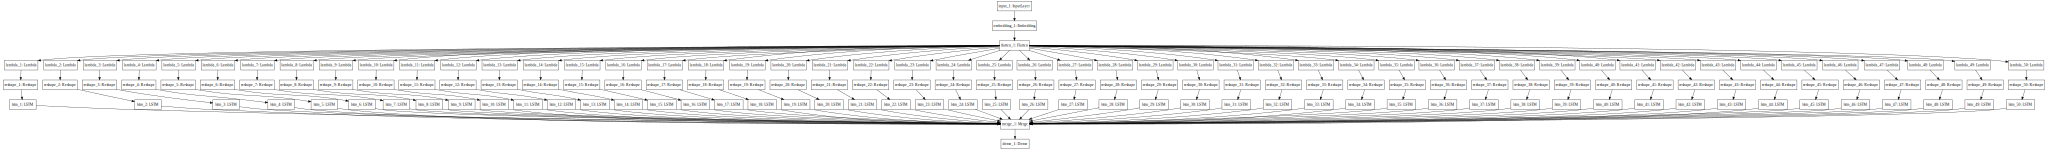

In [20]:
embedding_layer = Embedding(VOCAB_SIZE, 
                            EMBEDDING_DIM, 
                            weights = [embedding_matrix],
                            input_length=EMBEDDING_INPUT_LENGTH,
                            trainable=False)

sequence_input = Input(shape=(EMBEDDING_INPUT_LENGTH, ))
x = embedding_layer(sequence_input)
x = Flatten()(x)
parts = []
for i in range(MAX_SENTENCES):
    y = Lambda(lambda x: x[:, i :: MAX_SENTENCES])(x) # Split by Num_sentences. We need an LSTM for each sentence
    z = Reshape((MAX_WORD_LENGTH,EMBEDDING_DIM), input_shape=(MAX_WORD_LENGTH * EMBEDDING_DIM ,))(y)
    l = LSTM(128)(z) # An LSTM for each sentence
    parts.append(l)
# Construct Document vector : 128 X MAX_SENTENCES
merged = merge(parts, mode='concat', concat_axis= 1)
# merged has the document representation  built from sentences 

preds = Dense(NUM_CLASSES, activation='softmax')(merged)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])
print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
model.fit(x_train, y_train,validation_data=(x_val, y_val),nb_epoch=5, batch_size=10)

Train on 690 samples, validate on 172 samples
Epoch 1/5
690/690 [==============================] - 405s - loss: 0.3860 - acc: 0.8348 - val_loss: 0.9978 - val_acc: 0.5872
Epoch 2/5
690/690 [==============================] - 403s - loss: 0.3719 - acc: 0.8420 - val_loss: 0.9924 - val_acc: 0.5640
Epoch 3/5
320/690 [============>.................] - ETA: 212s - loss: 0.2810 - acc: 0.9031

In [23]:
score = model.evaluate(x_val, y_val)
print(score)

172/172 [==============================] - 10s    
[0.86166602650354074, 0.59883720930232553]
